## Clustering Seattle Neighborhoods
- based on:

* Accessibility Issue Points Density (access_point_count): Total number of accessibility points recorded within a neighborhood. This serves as a proxy for the absolute density or complexity of access-related infrastructure, independent of population composition.
- (*) of total accessibility issue points
 
* Demographic Vulnerability (vulnerable_ratio): Proportion of transportation-vulnerable populations (seniors over 65 and childeren under 18) within a neighborhood. This variable captures the structural vulnerability of the population that may be more exposed to traffic risks.
- Seniors over 65 and Children under 18 / Total population

* Population-normalized Accident Frequency (accident_rate): Number of traffic accidents normalized by neighborhood population. This measures the relative frequency of accidents, controlling for neighborhood size.
- (*) of Pedestrian-involved collisions / Total Population

* Accessibility Issue Points Composition (pct_<label_type>): Proportion of accessibility points of a specific label_type within a neighborhood. This variable represents the composition of access infrastructure, highlighting the dominant spatial or functional characteristics of the area.
- (*) of accessibility issue points belonging to a specific label type / (*) of total accessibility issue points

In [79]:
# Package import
import pandas as pd
import numpy as np

In [80]:
# Load Datasets
access = pd.read_csv('access.csv')
demo = pd.read_csv('demographics.csv')
acc = pd.read_csv('accident.csv')

In [81]:
access['properties/label_type'].value_counts()

properties/label_type
CurbRamp          27175
NoSidewalk        19133
NoCurbRamp        16947
SurfaceProblem    12681
Obstacle           5693
Occlusion           253
Other                91
Name: count, dtype: int64

In [82]:
# Create data for clustering by aggregating original datasets based on neighborhoods
# + Feature Engineering

# Base table (GEN_ALIAS universe from access)
data = (
    access[['GEN_ALIAS']]
    .drop_duplicates()
    .set_index('GEN_ALIAS')
)

# access_point_count
access_count = access.groupby('GEN_ALIAS').size()
data['access_point_count'] = access_count

# pct_<label_type>
label_counts = (
    access
    .groupby(['GEN_ALIAS', 'properties/label_type'])
    .size()
    .unstack(fill_value=0)
)

label_ratio = label_counts.div(label_counts.sum(axis=1), axis=0)

selected_labels = [
    'CurbRamp',
    'NoSidewalk',
    'NoCurbRamp',
    'SurfaceProblem'
]     # top4 labels

for lbl in selected_labels:
    data[f'pct_{lbl}'] = label_ratio[lbl]

data[[f'pct_{lbl}' for lbl in selected_labels]] = (
    data[[f'pct_{lbl}' for lbl in selected_labels]].fillna(0)
)

# accident_rate (per capita)
accident_count = acc.groupby('GEN_ALIAS').size()
demo_total = (
    demo
    .groupby('GEN_ALIAS')['Total']
    .sum()
)
data['accident_rate'] = accident_count / demo_total
data['accident_rate'] = data['accident_rate'].fillna(0)

# vulnerable_ratio
demo_agg = (
    demo
    .groupby('GEN_ALIAS')[['Total', 'Older_Adults_65_over', 'Children_under_18']]
    .sum()
)

data['vulnerable_ratio'] = (
    (demo_agg['Older_Adults_65_over'] + demo_agg['Children_under_18'])
    / demo_agg['Total']
)

In [83]:
# Final feature table
features = [
    'vulnerable_ratio',
    'accident_rate',
    'access_point_count',
    'pct_CurbRamp',
    'pct_NoSidewalk',
    'pct_NoCurbRamp',
    'pct_SurfaceProblem'
]


X = data[features]
X.describe()

,vulnerable_ratio,accident_rate,access_point_count,pct_CurbRamp,pct_NoSidewalk,pct_NoCurbRamp,pct_SurfaceProblem
count,53.000000,54.000000,53.000000,54.000000,54.000000,54.000000,54.000000
mean,0.277947,0.011462,1545.547170,0.336741,0.250007,0.174365,0.138868
std,0.092150,0.017047,1205.177302,0.185032,0.242268,0.110529,0.071663
min,0.059003,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000
25%,0.212597,0.004935,507.000000,0.228132,0.060072,0.080518,0.084337
50%,0.286273,0.007118,1151.000000,0.311737,0.174578,0.166806,0.134396
75%,0.341331,0.009679,2330.000000,0.424953,0.349403,0.252896,0.178908
max,0.443162,0.094535,4703.000000,0.722861,0.892384,0.468761,0.374701


In [84]:
# Drop rows with NaN
data['access_point_count'] = data['access_point_count'].fillna(0)
data = data.dropna(subset=['vulnerable_ratio'])
X = data[features]

In [85]:
# Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

# sanity check
X_scaled.describe()

,vulnerable_ratio,accident_rate,access_point_count,pct_CurbRamp,pct_NoSidewalk,pct_NoCurbRamp,pct_SurfaceProblem
count,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01
mean,-2.639398e-16,1.806731e-16,-2.094760e-17,-2.068576e-16,-1.990022e-17,-1.843389e-16,1.382542e-16
std,1.009570e+00,1.009570e+00,1.009570e+00,1.009570e+00,1.009570e+00,1.009570e+00,1.009570e+00
min,-2.398683e+00,-6.209685e-01,-1.264538e+00,-1.601848e+00,-1.062346e+00,-1.601142e+00,-1.641973e+00
25%,-7.159545e-01,-3.881882e-01,-8.699846e-01,-5.685577e-01,-7.832553e-01,-8.973956e-01,-7.903931e-01
50%,9.120967e-02,-2.679206e-01,-3.305097e-01,-1.646781e-01,-3.182684e-01,-9.928466e-02,-7.827121e-02
75%,6.944158e-01,-1.104960e-01,6.571313e-01,4.882762e-01,4.156149e-01,7.435051e-01,6.051594e-01
max,1.810038e+00,4.881738e+00,2.644979e+00,2.121067e+00,2.659403e+00,2.699108e+00,3.378496e+00


In [86]:
# K-Means Clustering

# Identifying the Best K Number with silhouette_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = {}
sil_scores = {}

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    
    inertias[k] = km.inertia_
    sil_scores[k] = silhouette_score(X_scaled, labels)

inertias, sil_scores

({2: 272.538926176018,
  3: 207.12958783152772,
  4: 162.27916006006075,
  5: 138.51207985450685,
  6: 119.54954309497148},
 {2: 0.29046923012800413,
  3: 0.2823474905009603,
  4: 0.3005539328777826,
  5: 0.2564078906434035,
  6: 0.2642387657932251})

In [87]:
# 4 is likely to be the best K.

In [88]:
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
data['cluster'] = km.fit_predict(X_scaled)

data.groupby('cluster')[features].mean()

,vulnerable_ratio,accident_rate,access_point_count,pct_CurbRamp,pct_NoSidewalk,pct_NoCurbRamp,pct_SurfaceProblem
cluster,,,,,,,
0,0.297218,0.006306,2070.423077,0.326270,0.154930,0.261299,0.178395
1,0.342230,0.006546,950.083333,0.144707,0.611407,0.070633,0.103672
2,0.224739,0.087488,2540.000000,0.173554,0.606814,0.066641,0.108852
3,0.188254,0.015498,892.461538,0.585952,0.070902,0.126234,0.107603


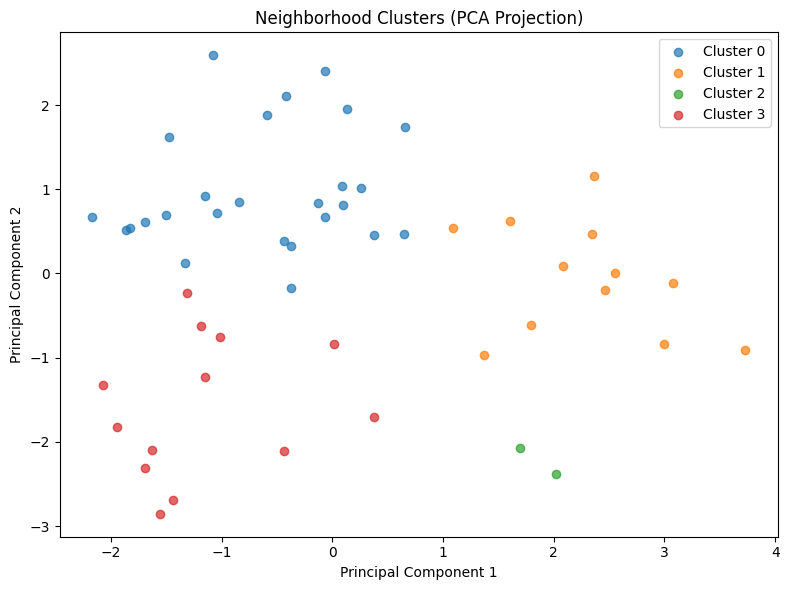

In [89]:
# Cluster visualization with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2'],
    index=X_scaled.index
)

pca_df['cluster'] = data.loc[X_scaled.index, 'cluster']

plt.figure(figsize=(8, 6))
for c in sorted(pca_df['cluster'].unique()):
    subset = pca_df[pca_df['cluster'] == c]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        label=f'Cluster {c}',
        alpha=0.7
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Neighborhood Clusters (PCA Projection)')
plt.legend()
plt.tight_layout()
plt.show()

Cluster 0 — High Issue Density, Mixed Accessibility Deficiencies, Low Accident Risk

Key characteristics
Cluster 0 has a relatively high number of accessibility issue points, with a mixed composition of curb ramp issues, missing curb ramps, and some missing sidewalks. The vulnerable population ratio is moderate, while the accident rate remains low.

Interpretation
This cluster represents neighborhoods where many accessibility issues are identified, but these issues do not translate into high accident risk. The results suggest that the volume of reported accessibility problems alone is not a sufficient indicator of traffic safety risk. Other contextual factors—such as traffic conditions or exposure—likely mitigate accident outcomes in these areas.

Cluster 1 — Sidewalk-Deficient, Vulnerable Residential Areas with Latent Risk

Key characteristics
Cluster 1 exhibits the highest vulnerable population ratio and a very high proportion of missing sidewalk issues, while the overall number of accessibility issue points and accident rates remain relatively low.

Interpretation
These neighborhoods represent latent-risk environments, where structural accessibility deficiencies coexist with a high share of vulnerable populations but have not yet resulted in elevated accident rates. This cluster is particularly important from a preventive perspective, as targeted sidewalk investments could reduce future safety risks before accidents increase.

Cluster 2 — Highest-Risk Neighborhoods with Severe Sidewalk Deficiencies

Key characteristics
Cluster 2 stands out with a substantially higher accident rate than all other clusters, the highest density of accessibility issue points, and a dominant presence of missing sidewalk issues. The vulnerable population ratio is moderate.

Interpretation
This cluster represents the most critical safety context identified in the analysis. The alignment of severe sidewalk deficiencies, high exposure (as implied by issue density), and elevated accident rates suggests a strong relationship between accessibility problems and adverse safety outcomes. These neighborhoods should be prioritized for immediate, targeted safety and infrastructure interventions.

Cluster 3 — Low-Risk Neighborhoods Dominated by Minor Accessibility Issues

Key characteristics
Cluster 3 has the lowest vulnerable population ratio and a relatively low number of accessibility issue points, with accessibility problems dominated by curb ramp–related issues rather than sidewalk deficiencies. Accident rates are slightly higher than in Clusters 0 and 1 but remain low overall.

Interpretation
This cluster reflects neighborhoods where accessibility concerns are largely limited to minor or maintenance-oriented issues that do not strongly correlate with elevated accident risk. These areas likely require routine infrastructure maintenance rather than comprehensive safety interventions and serve as a baseline low-risk category.

Overall Takeaway

Across clusters, the analysis shows that the type of accessibility deficiency—especially sidewalk absence—matters more than the total number of reported issues. High accident risk is concentrated in neighborhoods where severe sidewalk deficiencies coincide with high exposure, while other accessibility issues appear less strongly linked to safety outcomes.

In [90]:
 
gdf = gpd.read_file('tract20_king_county.shp')

gdf_cluster = gdf.merge(
    data[['cluster']],
    left_on='GEN_ALIAS',
    right_index=True,
    how='inner'
)

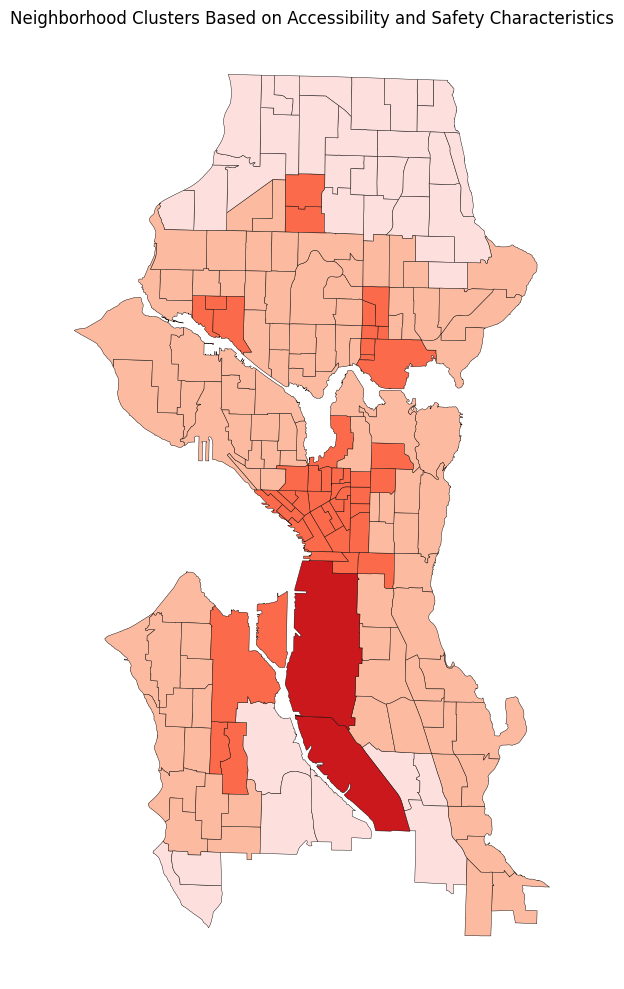

In [103]:
cluster_colors = {
    1: '#fde0dd',  # very light red (lowest risk)
    0: '#fcbba1',  # light red
    3: '#fb6a4a',  # medium red
    2: '#cb181d'   # dark red (highest risk)
}

gdf_cluster['cluster_color'] = gdf_cluster['cluster'].map(cluster_colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_cluster.plot(
    color=gdf_cluster['cluster_color'],
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=ax
)

ax.set_title('Neighborhood Clusters Based on Accessibility and Safety Characteristics')
ax.axis('off')

plt.tight_layout()
plt.show()

In [92]:
cluster_areas = (
    data
    .reset_index()
    .groupby('cluster')['GEN_ALIAS']
    .apply(list)
    .reset_index(name='Neighborhoods')
)

cluster_areas

,cluster,Neighborhoods
0,0,"[Madrona/Leschi, Mt. Baker/North Rainier, Nort..."
1,1,"[Wedgwood/View Ridge, Northgate/Maple Leaf, Ol..."
2,2,"[Georgetown, Duwamish/SODO]"
3,3,"[Judkins Park, Ballard, Belltown, Downtown Com..."


In [93]:
cluster_means = data.groupby('cluster')[features].mean()
cluster_means

,vulnerable_ratio,accident_rate,access_point_count,pct_CurbRamp,pct_NoSidewalk,pct_NoCurbRamp,pct_SurfaceProblem
cluster,,,,,,,
0,0.297218,0.006306,2070.423077,0.326270,0.154930,0.261299,0.178395
1,0.342230,0.006546,950.083333,0.144707,0.611407,0.070633,0.103672
2,0.224739,0.087488,2540.000000,0.173554,0.606814,0.066641,0.108852
3,0.188254,0.015498,892.461538,0.585952,0.070902,0.126234,0.107603


In [94]:
base_score = silhouette_score(X_scaled, data['cluster'])

drop_impact = {}

for f in features:
    reduced_features = [x for x in features if x != f]
    
    X_red = X_scaled[reduced_features]
    km = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = km.fit_predict(X_red)
    
    drop_impact[f] = base_score - silhouette_score(X_red, labels)

pd.Series(drop_impact).sort_values(ascending=False)

pct_CurbRamp          0.037730
accident_rate         0.034491
pct_NoSidewalk        0.033492
pct_NoCurbRamp        0.024577
pct_SurfaceProblem   -0.025331
vulnerable_ratio     -0.044281
access_point_count   -0.057195
dtype: float64

In [95]:
# Additional Visualization

# Merge all variables into geodataframe
gdf_viz = gdf.merge(
    data[['cluster',
          'accident_rate',
          'vulnerable_ratio',
          'access_point_count',
          'pct_NoSidewalk']],
    left_on='GEN_ALIAS',
    right_index=True,
    how='left'
)

# add total population
gdf_viz = gdf_viz.merge(
    demo_agg[['Total']],
    left_on='GEN_ALIAS',
    right_index=True,
    how='left'
)

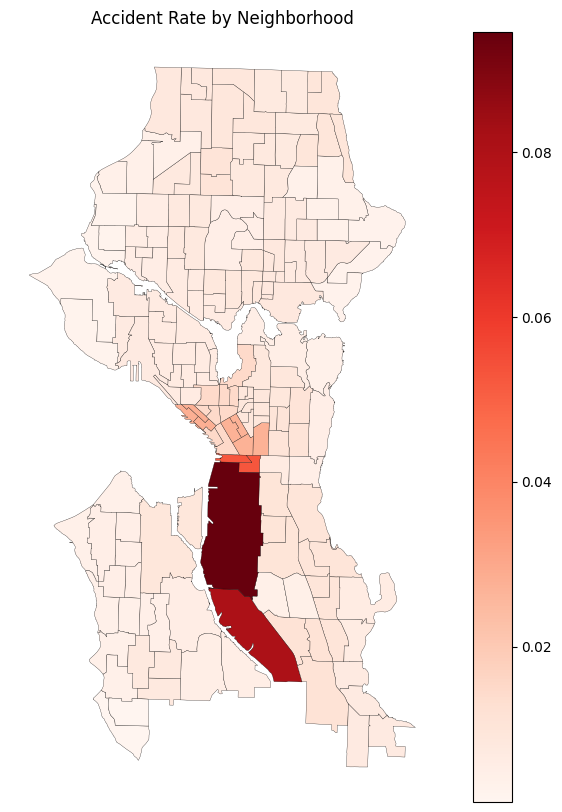

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_viz.plot(
    column='accident_rate',
    cmap='Reds',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)
ax.set_title('Accident Rate by Neighborhood')
ax.axis('off')
plt.show()

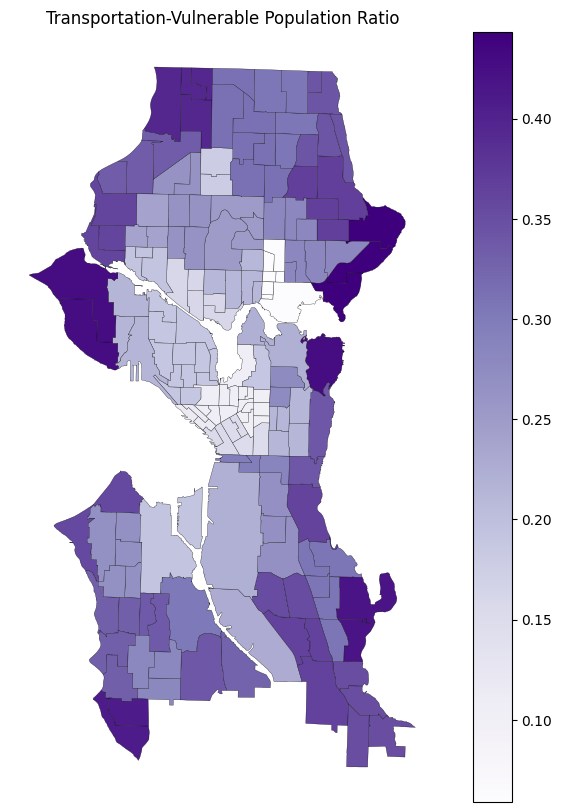

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_viz.plot(
    column='vulnerable_ratio',
    cmap='Purples',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)
ax.set_title('Transportation-Vulnerable Population Ratio')
ax.axis('off')
plt.show()

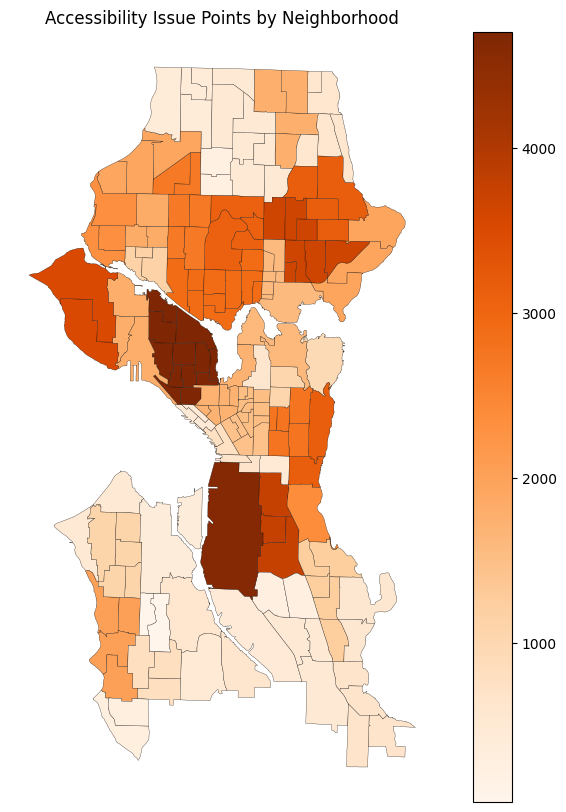

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_viz.plot(
    column='access_point_count',
    cmap='Oranges',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)
ax.set_title('Accessibility Issue Points by Neighborhood')
ax.axis('off')
plt.show()


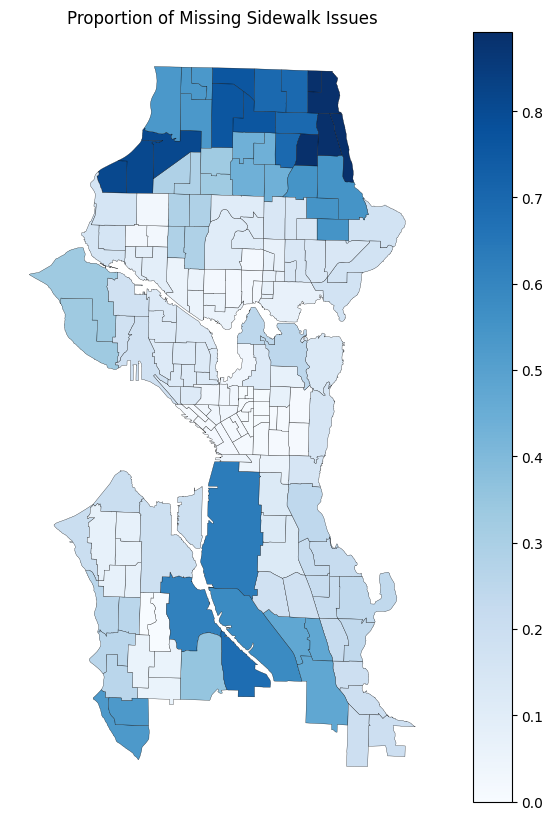

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_viz.plot(
    column='pct_NoSidewalk',
    cmap='Blues',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)
ax.set_title('Proportion of Missing Sidewalk Issues')
ax.axis('off')
plt.show()

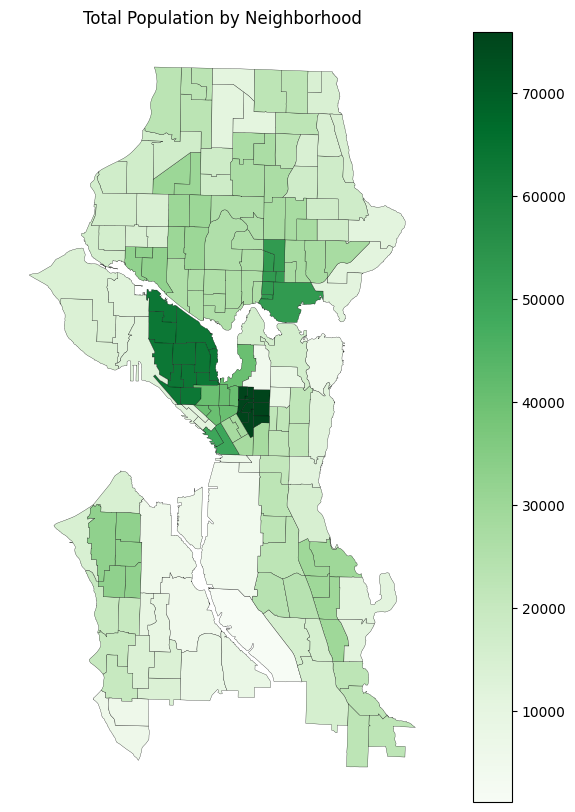

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_viz.plot(
    column='Total',
    cmap='Greens',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)
ax.set_title('Total Population by Neighborhood')
ax.axis('off')
plt.show()
